In [1]:
import os
import numpy as np
import h5py
from scipy import stats
import scipy.io
import mne
from random import shuffle
import random

mne.set_log_level('error')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import optuna


from utils.load import Load
from config.default import cfg

%load_ext autoreload
%autoreload 2


##### Load EEG data in MNE format to access electrode position

In [2]:
data_root = 'C:/Data/UHD_EEG/'

subjects = ['S1', 'S2', 'S3', 'S4', 'S5']
dominant_hand = ['left','right','right','right','right']
mapping = {0: "No instruction", 1: "Rest", 2: "thumb", 3: "index", 4: "middle", 5: "ring", 6: "little"}


def get_montage(hemishpere):
    mat = scipy.io.loadmat(os.path.join(data_root, 'montage', f'montage_256_{hemishpere}_hemisphere.mat'))
    return mat['pos_256']

left_handed_montage = get_montage('right')
right_handed_montage = get_montage('left')


def load_run(subject_id, run, describe=True):
    subject = subjects[subject_id]
    mat = scipy.io.loadmat(os.path.join(data_root, 'rawdata', subject, run))
    data = mat['y'][1:]  # remove timestamp
    ch_names = [f'c{i}' for i in range(1, 257)] + ['STIM']
    info = mne.create_info(ch_names=ch_names, sfreq=mat['SR\x00'][0][0])

    raw = mne.io.RawArray(data, info)
    ch_types = {ch: 'eeg' if ch != 'STIM' else 'stim' for ch in ch_names}
    raw.set_channel_types(ch_types)

    events = mne.find_events(raw, stim_channel='STIM')
    annot_from_events = mne.annotations_from_events(events, event_desc=mapping, sfreq=raw.info['sfreq'])
    raw.set_annotations(annot_from_events)
    raw.drop_channels(['STIM'])

    montage_positions = left_handed_montage if dominant_hand[subject_id] == 'left' else right_handed_montage
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, montage_positions)), coord_frame='head')
    raw.set_montage(montage)

    if describe:
        raw.describe()
    return raw
demo = load_run(0, 'S1_run1.mat', describe=False)

#### Training

In [3]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
print(device)

cuda


In [4]:
# Set seed for NumPy
np.random.seed(42)

# Set seed for Python's built-in random number generator
random.seed(42)

# Set seed for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
subject_id = 0


In [6]:
# Load the dictionary from the HDF5 file
target_dir = 'features'
tag = 'reproduced'

file_path = os.path.join(target_dir, tag+'_'+cfg['subjects'][subject_id] + '.h5')


data = {}
with h5py.File(file_path, 'r') as h5file:
    for key in h5file.keys():
        data[key] = np.array(h5file[key])

# Print the loaded data dictionary
for key, value in data.items():
    #data[key] = np.reshape(value, (value.shape[0], -1))
    print(key, data[key].shape)

index (50, 153, 26, 2)
little (50, 153, 26, 2)
middle (50, 153, 26, 2)
ring (50, 153, 26, 2)
thumb (50, 153, 26, 2)


In [7]:
class SingleLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation):
        super(SingleLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        x = x.view(x.size(0), -1)
 
        x = self.fc1(x)
      
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [8]:
def train(X_train, y_train, X_test, y_test, model, criterion, optimizer, num_epochs=100):
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)


    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        y_pred = model(X_test)
        y_pred = torch.argmax(y_pred, dim=1)

    acc = accuracy_score(y_test.cpu(), y_pred.cpu())
    return acc


finger1 = 'middle'
finger2 = 'ring'
learning_rate = 0.0028774322222191256
num_epochs= 1860
hidden_size =47
activation =nn.ReLU()
optimizer = optim.SGD


X = np.concatenate((data[finger1], data[finger2]), axis=0)
y = np.concatenate((np.ones(data[finger1].shape[0]), np.zeros(data[finger2].shape[0])), axis=0)

   
# Normalize the data
orig_shape = X.shape
X = X.reshape(X.shape[0], -1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(orig_shape)



model = SingleLayerMLP(X.shape[1]*X.shape[2]*X.shape[3], hidden_size, 2, activation)
model.to(device)

########################################
###########  WARNING      ##############
########################################
# shuffle = False -> acc ~ 0.8
# shuffle = True -> acc ~ 0.5
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer(model.parameters(), lr=learning_rate)

train(train_X, train_y, test_X, test_y, model, criterion, optimizer, num_epochs=num_epochs)



0.5

middle


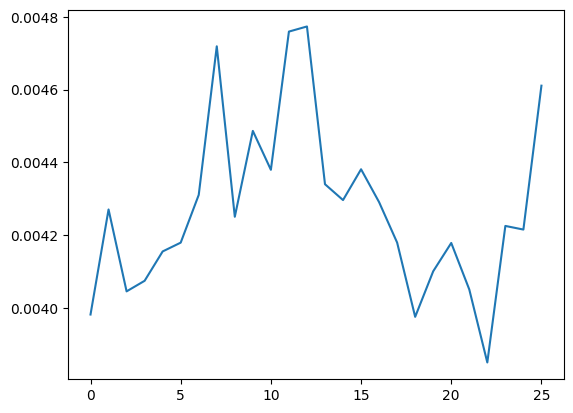

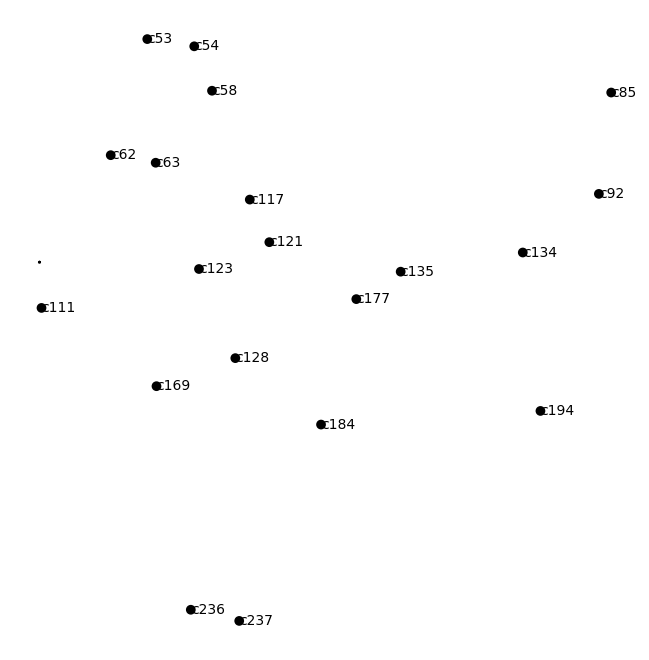

ring


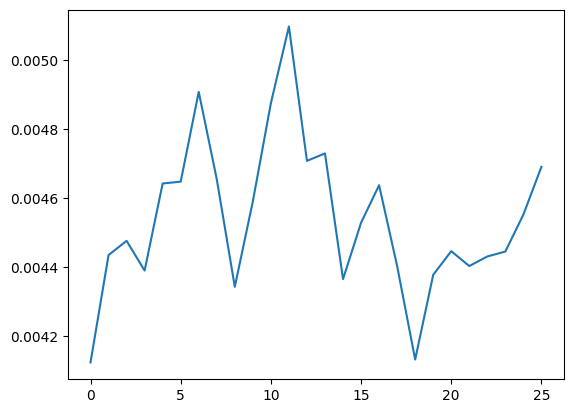

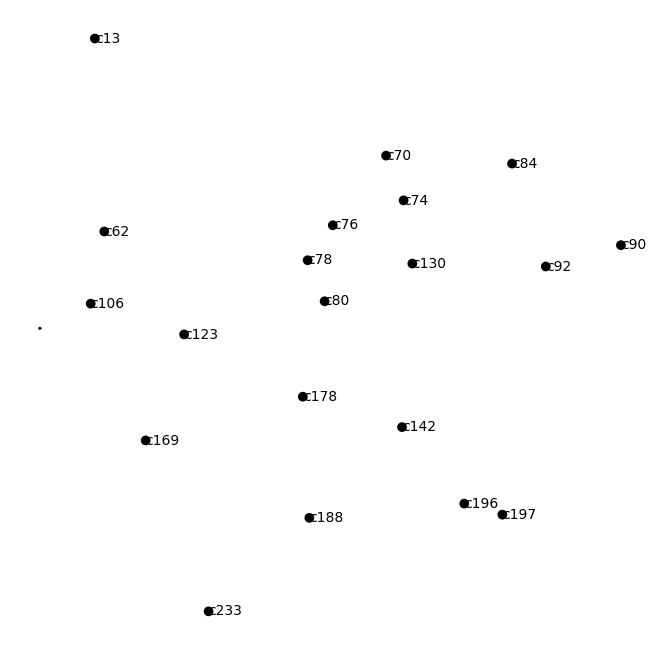

In [9]:
top = 20

model.eval()
# Print the loaded data dictionary
for key, features in data.items(): # BOTH Train and Test
    if key in ['middle', 'ring']:
        print(key)
        limit = 40
        channel_result = np.empty((limit, features.shape[1]))
        time_result = np.empty((limit, features.shape[2]))
        for i, f in enumerate(features):

            X = torch.from_numpy(f).float().to(device)

            X = X.unsqueeze(0)

            X.requires_grad_(True)

        
            outputs = model(X)

            max_scores = outputs.max(dim=1)[0]
        
            max_scores.backward(retain_graph=True)

            saliency = X.grad
           
            saliency = saliency.squeeze(0)              # REMOVE BATCH DIMENSION
            saliency = saliency.abs()                   # ABSOLUTE VALUE
            saliency = torch.max(saliency, dim=-1)[0]   # MAX OVER FREQUNCY BANDS

            time_saliency = saliency
            time_saliency = torch.mean(time_saliency, dim=0)      # MEAN OVER CHANNELS
            time_saliency = time_saliency.cpu().detach().numpy()  # CONVERT TO NUMPY ARRAY
       
            time_result[i] = time_saliency
           

            channel_saliency = torch.mean(saliency, dim=1)      # MEAN OVER TIME
            channel_saliency = channel_saliency.cpu().detach().numpy()  # CONVERT TO NUMPY ARRAY
            channel_result[i] = channel_saliency

            if i == limit-1:
                break

        time_average = np.mean(time_result, axis=0)
        plt.plot(time_average)

        ################### Saliency Sensor Plot ###################
        channel_average = np.mean(channel_result, axis=0)
        bests = np.argpartition(channel_average, -top)[-top:]
        #best_channels = [cfg['not_ROI_channel_names'][i] for i in bests]
        best_channels = [cfg['kept_channel_names']['S1'][i] for i in bests]
        #print(best_channels)
        saliency =  demo.copy().pick_channels(best_channels)
        saliency.plot_sensors(show_names=True);
        plt.show()


